# Imports

In [1]:
import tensorflow as tf
import numpy as np
import cv2
from imutils.object_detection import non_max_suppression
from google.colab.patches import cv2_imshow
import time
from imutils import paths

In [2]:
IMAGE_LIST = list(paths.list_images("/content/Images"))
IMG_SIZE = 320
quantization = "int8"
#Options: "dr", "int8", "float16"

# TensorFlow Lite Model

In [3]:
def representative_dataset_gen():
    for image_path in IMAGE_LIST:
        image = cv2.imread(image_path)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image = image.astype("float32")  # Convert to float32
        # Normalize the image as required by the original model
        mean = np.array([123.68, 116.779, 103.939][::-1], dtype="float32")
        image -= mean
        image = np.expand_dims(image, axis=0)
        yield [image]



# Set the quantization parameter
quantization = "float32"  #@param ["dr","int8", "float16", "float32" ]

# TensorFlow Lite model conversion
converter = tf.compat.v1.lite.TFLiteConverter.from_frozen_graph(
    graph_def_file='/content/text-detection-opencv-east/frozen_east_text_detection.pb',
    input_arrays=['input_images'],
    output_arrays=['feature_fusion/Conv_7/Sigmoid', 'feature_fusion/concat_3'],
    input_shapes={'input_images': [1, 320, 320, 3]}
)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
if quantization == "float16":
    converter.target_spec.supported_types = [tf.float16]
elif quantization == "int8":
    converter.representative_dataset = representative_dataset_gen
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.uint8
    converter.inference_output_type = tf.uint8

tflite_model = converter.convert()
open('east_model_{}.tflite'.format(quantization), 'wb').write(tflite_model)



24492768

In [4]:
tflite_model_path = 'east_model_float32.tflite'


# Preprocessing Images

In [5]:
def preprocess_images(image_paths, img_size=320):
    images, original_images, ratios = [], [], []
    for image_path in image_paths:
        image = cv2.imread(image_path)
        orig = image.copy()
        H, W = image.shape[:2]

        newW, newH = img_size, img_size
        rW = W / float(newW)
        rH = H / float(newH)

        image = cv2.resize(image, (newW, newH))
        image = image.astype("float32")
        mean = np.array([123.68, 116.779, 103.939][::-1], dtype="float32")
        image -= mean

        images.append(image)
        original_images.append(orig)
        ratios.append((rW, rH))

    # Stack images into a single numpy array
    images = np.array(images, dtype="float32")

    return images, original_images, ratios


# Performance Inference

In [6]:
def perform_inference(tflite_model_path, preprocessed_images):
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Reshape preprocessed_images if necessary
    input_shape = input_details[0]['shape']
    if not np.array_equal(preprocessed_images.shape, input_shape):
        preprocessed_images = np.reshape(preprocessed_images, input_shape)

    interpreter.set_tensor(input_details[0]['index'], preprocessed_images)
    interpreter.invoke()

    scores = interpreter.get_tensor(output_details[0]['index'])
    geometry = interpreter.get_tensor(output_details[1]['index'])

    return scores, geometry


# Post-Processing

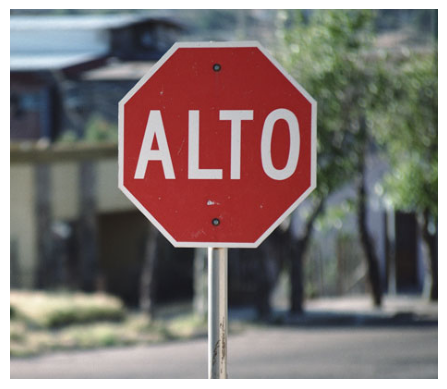

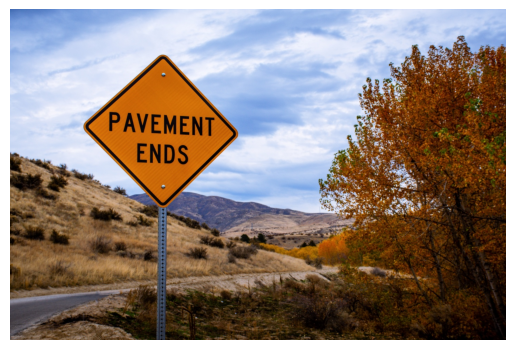

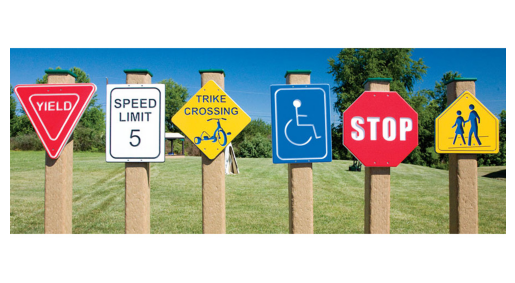

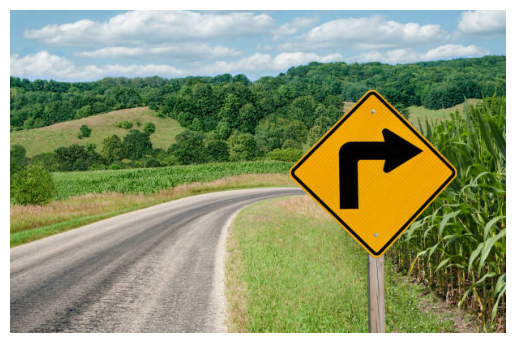

In [26]:
from google.colab.patches import cv2_imshow
from imutils.object_detection import non_max_suppression
from matplotlib import pyplot as plt
import random

def post_process(scores, geometry, ratios, original_images):
    for score, geo, (ratioW, ratioH), orig in zip(scores, geometry, ratios, original_images):
        num_rows, num_cols = score.shape[1:3]
        rects, confidences = [], []

        for y in range(min(num_rows, geo.shape[2])):
            scores_data = score[0, y]
            x_data0 = geo[0, 0, y]
            x_data1 = geo[0, 1, y]
            x_data2 = geo[0, 2, y]
            x_data3 = geo[0, 3, y]

            for x in range(min(num_cols, len(scores_data))):
                if scores_data[x] < 0.5:
                    continue

                offsetX, offsetY = x * 4.0, y * 4.0
                h = x_data0[x] + x_data2[x]
                w = x_data1[x] + x_data3[x]

                endX = int(offsetX + w)
                endY = int(offsetY + h)
                startX = int(offsetX)
                startY = int(offsetY)

                rects.append((startX, startY, endX, endY))
                confidences.append(scores_data[x])

        # Apply non-maximum suppression to the bounding boxes
        boxes = non_max_suppression(np.array(rects), probs=confidences, overlapThresh=0.5)

        # Draw bounding boxes on the original image
        for (startX, startY, endX, endY) in boxes:
            startX = int(startX * ratioW)
            startY = int(startY * ratioH)
            endX = int(endX * ratioW)
            endY = int(endY * ratioH)
            cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)

        # Display the image with bounding boxes using Matplotlib
        plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
        plt.axis('off')


# Load the code and functions
tflite_model_path = 'east_model_float32.tflite'
IMAGE_LIST = list(paths.list_images("/content/Images"))

# Perform inference on each image
for image_path in IMAGE_LIST:
    # Read and preprocess the image
    image = cv2.imread(image_path)
    preprocessed_image, original_image, ratios = preprocess_images([image_path])

    # Perform inference
    scores, geometry = perform_inference(tflite_model_path, preprocessed_image)

    # Post-process and draw bounding boxes
    post_process(scores, geometry, ratios, original_image)


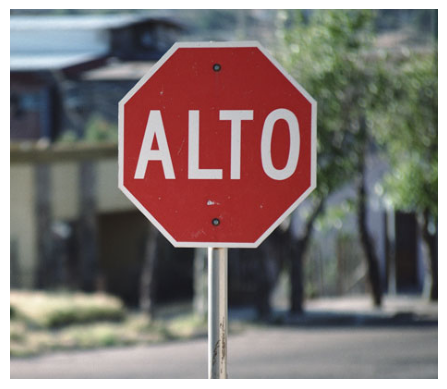

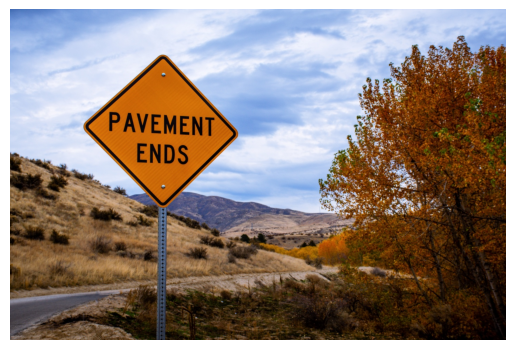

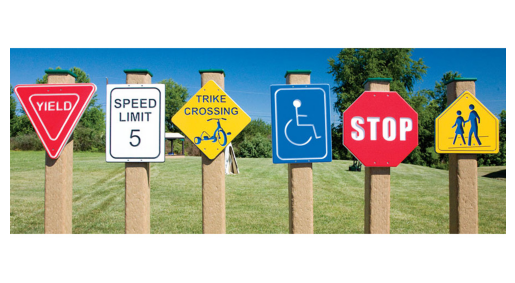

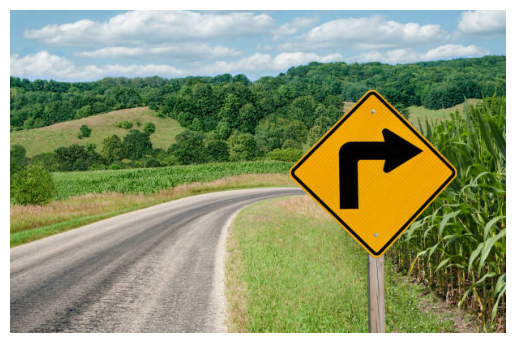

In [25]:
# Load the code and functions

# Replace the tflite_model_path with the correct path to your TensorFlow Lite model
tflite_model_path = 'east_model_float32.tflite'

# Replace the IMAGE_LIST with the list of image paths
IMAGE_LIST = list(paths.list_images("/content/Images"))

# Perform inference on each image
for image_path in IMAGE_LIST:
    # Read and preprocess the image
    image = cv2.imread(image_path)
    preprocessed_image, original_image, ratios = preprocess_images([image_path])

    # Perform inference
    scores, geometry = perform_inference(tflite_model_path, preprocessed_image[0])

    # Post-process and draw bounding boxes
    post_process(scores, geometry, ratios, original_image)
